# Dimensionality Reduction Analysis

Dit notebook analyseert de dataset met drie verschillende dimensionality reduction technieken:
- **PCA**: Principal Component Analysis - lineaire techniek die variantie maximaliseert
- **T-SNE**: t-Distributed Stochastic Neighbor Embedding - niet-lineaire techniek voor lokale structuur
- **UMAP**: Uniform Manifold Approximation and Projection - snel en bewaart globale en lokale structuur

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [3]:
# Load the dataset
df = pd.read_csv('Uitgebreide_VKM_dataset_cleaned.csv')

In [4]:
# Prepare data for dimensionality reduction
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

print(f"Numeric columns: {numeric_df.shape[1]}")
print(f"Samples: {numeric_df.shape[0]}")

# Handle missing values
numeric_df = numeric_df.fillna(numeric_df.mean())

# Standardize the features (important for all three methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

print(f"\nData standardized. Shape: {X_scaled.shape}")

Numeric columns: 7
Samples: 211

Data standardized. Shape: (211, 7)


## 1. PCA (Principal Component Analysis)

**Wat laat het zien:**
- PCA is een lineaire techniek die de datavariatie naar een kleiner aantal dimensies comprimert
- Het zoekt naar de richtingen (componenten) waarin de meeste variantie in de data zit
- Goed voor het begrijpen van welke features het meest belangrijk zijn
- Behoudt globale structuur, maar verliest mogelijk interessante lokale clusters

**Voordelen:**
- Snel en schaalbaar
- Interpreteerbaarheid (componenten zijn lineaire combinaties van features)
- Goed voor het zien van de algemene structuur van de data

In [5]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a dataframe with PCA results
pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)

# Display explained variance
print(f"Explained Variance Ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"Total: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

print(f"\nTop 5 features contributing to PC1:")
pc1_contrib = pd.DataFrame(
    {'Feature': numeric_df.columns, 'Contribution': abs(pca.components_[0])}
).sort_values('Contribution', ascending=False)
print(pc1_contrib.head())

Explained Variance Ratio:
PC1: 0.2722 (27.22%)
PC2: 0.1676 (16.76%)
Total: 0.4398 (43.98%)

Top 5 features contributing to PC1:
                 Feature  Contribution
2             contact_id      0.701650
0                     id      0.699348
4       popularity_score      0.106246
6        available_spots      0.062877
3  interests_match_score      0.040265


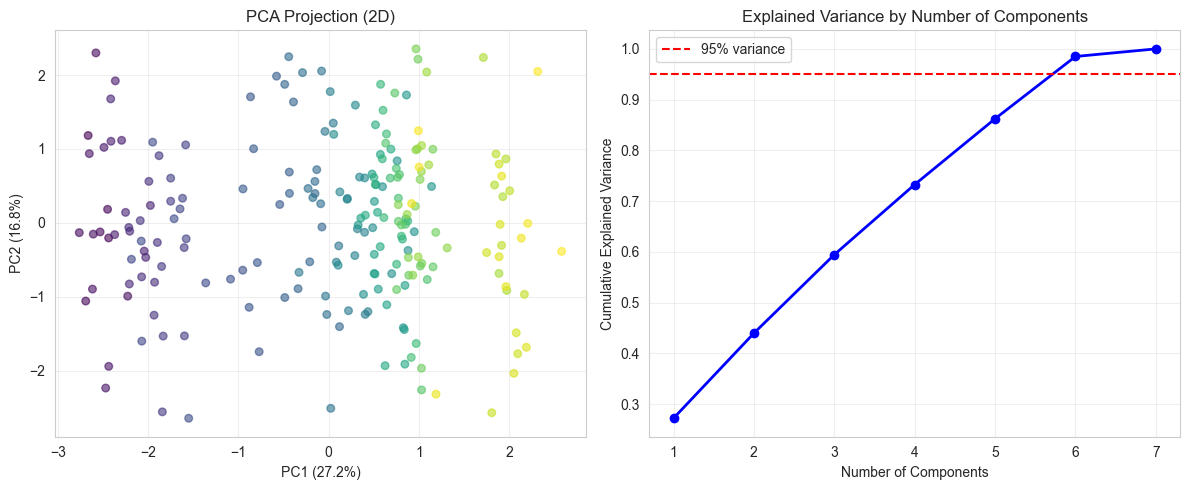

Original dimensions: 7
Reduced to: 2 dimensions
Information retained: 43.98%


In [6]:
# Visualize PCA
plt.figure(figsize=(12, 5))

# Plot 1: PCA scatter
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=30, c=range(len(pca_df)), cmap='viridis')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA Projection (2D)')
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
pca_full = PCA()
pca_full.fit(X_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced to: 2 dimensions")
print(f"Information retained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

## 2. T-SNE (t-Distributed Stochastic Neighbor Embedding)

**Wat laat het zien:**
- T-SNE is een niet-lineaire techniek die lokale clusters en structuur bewaart
- Het probeert punten die dicht bij elkaar liggen in de originele ruimte ook dicht bij elkaar te houden in de 2D ruimte
- Erg goed voor het zien van clusters en groepen
- Kan misleidend zijn voor globale structuur (afstanden tussen clusters zijn niet altijd betekenisvol)

**Voordelen:**
- Reveals lokale cluster-structuur zeer duidelijk
- Goed voor exploratory data analysis
- Gebruikelijk in machine learning visualisaties

**Nadelen:**
- Traag voor grote datasets
- Niet deterministisch (verschillende runs geven andere resultaten)
- Globale afstanden zijn niet betekenisvol

In [8]:
# Apply T-SNE
print("Calculating T-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_scaled)

# Create a dataframe with T-SNE results
tsne_df = pd.DataFrame(
    X_tsne,
    columns=['TSNE1', 'TSNE2']
)

print(f"T-SNE transformation complete")
print(f"Shape: {X_tsne.shape}")

# Check for clusters
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(X_tsne))
avg_distance = np.mean(distances)
print(f"Average distance between points: {avg_distance:.2f}")

Calculating T-SNE (this may take a moment)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 211 samples in 0.000s...
[t-SNE] Computed neighbors for 211 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 1.323364
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.081367
[t-SNE] KL divergence after 1000 iterations: 0.662582
T-SNE transformation complete
Shape: (211, 2)
Average distance between points: 12.81


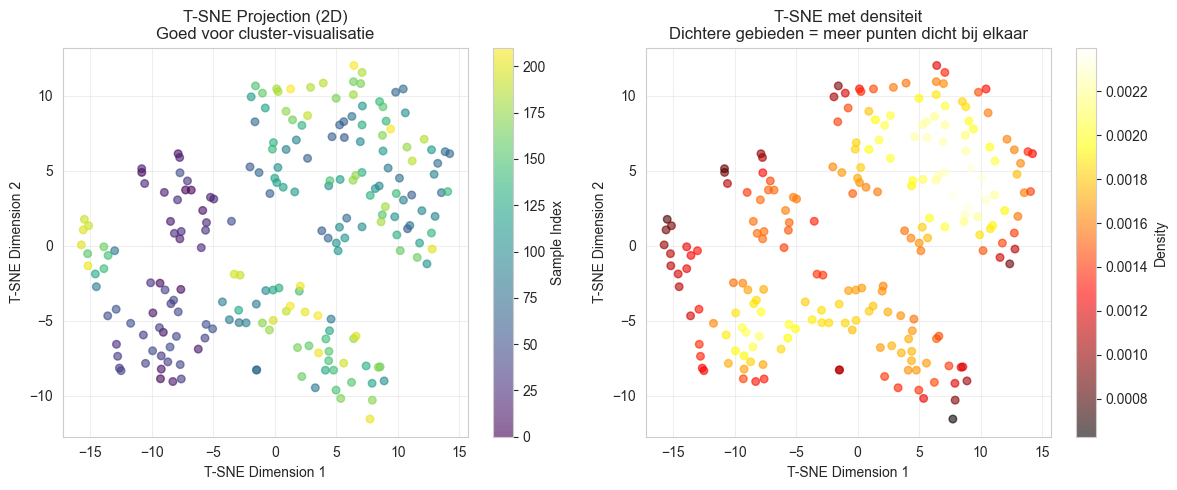


Gedetecteerde clusters (DBSCAN): 1
Noise points: 0


In [9]:
# Visualize T-SNE
plt.figure(figsize=(12, 5))

# Plot 1: T-SNE scatter
plt.subplot(1, 2, 1)
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.6, s=30, c=range(len(tsne_df)), cmap='viridis')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.title('T-SNE Projection (2D)\nGoed voor cluster-visualisatie')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Sample Index')

# Plot 2: Comparison - PCA vs T-SNE
plt.subplot(1, 2, 2)
# Create density plot for T-SNE
from scipy.stats import gaussian_kde
xy = np.vstack([tsne_df['TSNE1'], tsne_df['TSNE2']])
z = gaussian_kde(xy)(xy)
scatter2 = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.6, s=30, c=z, cmap='hot')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.title('T-SNE met densiteit\nDichtere gebieden = meer punten dicht bij elkaar')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter2, label='Density')

plt.tight_layout()
plt.show()

# Analyze clusters
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=5, min_samples=5).fit(X_tsne)
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
print(f"\nGedetecteerde clusters (DBSCAN): {n_clusters}")
print(f"Noise points: {list(clustering.labels_).count(-1)}")

## 3. UMAP (Uniform Manifold Approximation and Projection)

**Wat laat het zien:**
- UMAP is een moderne, niet-lineaire dimensionality reduction techniek
- Het bewaart zowel lokale als globale structuur van de data
- Sneller dan T-SNE en vaak beter in het behouden van globale patronen
- Gebaseerd op topologische principia (manifold learning)

**Voordelen:**
- Sneller dan T-SNE
- Bewaart beter zowel globale als lokale structuur
- Schaalbaar naar grotere datasets
- Minder gevoelig voor parameters

**Nadelen:**
- Moeilijker te interpreteren dan PCA
- Kan nog steeds misleidend zijn voor globale afstanden
- Minder onderzoeks- en theoretische basis dan PCA

In [10]:
# Apply UMAP
print("Calculating UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Create a dataframe with UMAP results
umap_df = pd.DataFrame(
    X_umap,
    columns=['UMAP1', 'UMAP2']
)

print(f"UMAP transformation complete")
print(f"Shape: {X_umap.shape}")

Calculating UMAP...
UMAP transformation complete
Shape: (211, 2)


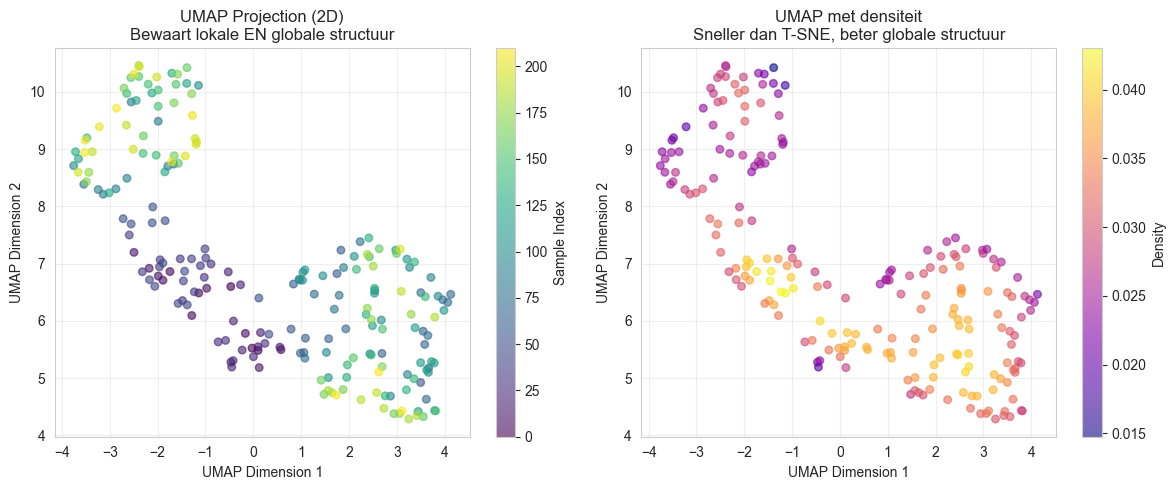

In [11]:
# Visualize UMAP
plt.figure(figsize=(12, 5))

# Plot 1: UMAP scatter
plt.subplot(1, 2, 1)
scatter = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6, s=30, c=range(len(umap_df)), cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection (2D)\nBewaart lokale EN globale structuur')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Sample Index')

# Plot 2: UMAP density
plt.subplot(1, 2, 2)
xy = np.vstack([umap_df['UMAP1'], umap_df['UMAP2']])
z = gaussian_kde(xy)(xy)
scatter2 = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6, s=30, c=z, cmap='plasma')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP met densiteit\nSneller dan T-SNE, beter globale structuur')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter2, label='Density')

plt.tight_layout()
plt.show()

## Vergelijking van alle drie technieken

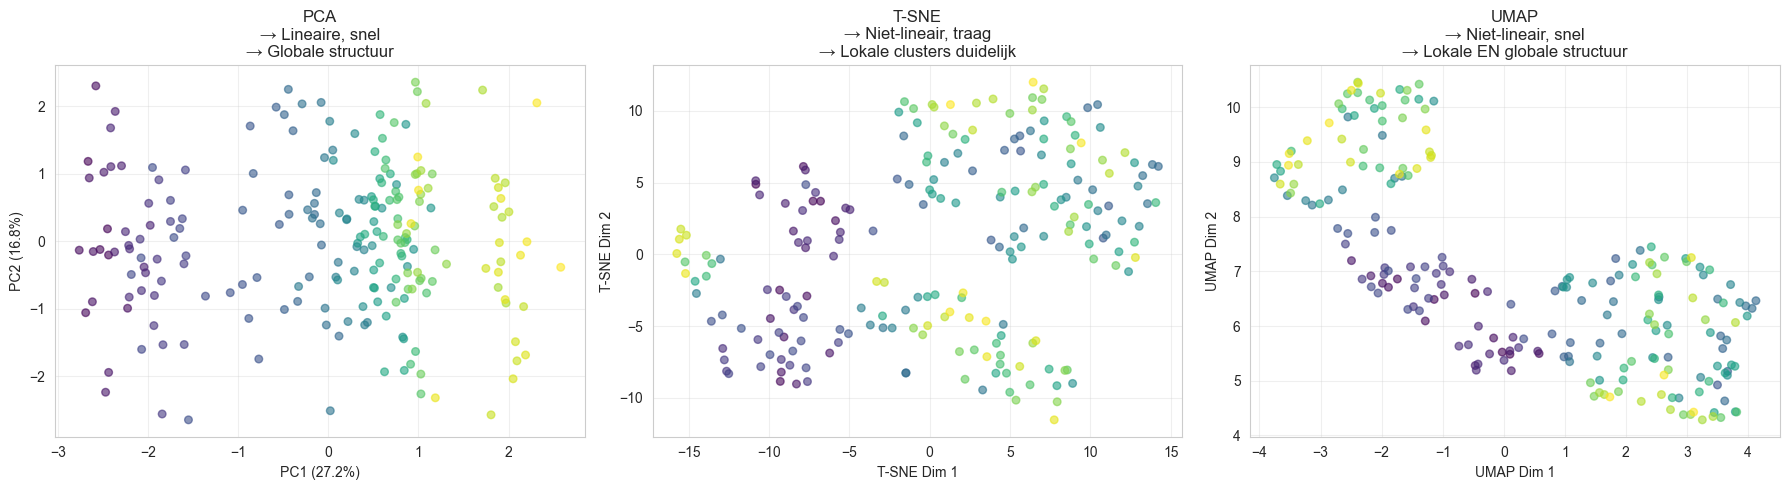


SAMENVATTING - WANNEER WELKE TECHNIEK GEBRUIKEN?

PCA:
  ✓ Snel en schaalbaar
  ✓ Goed voor feature importance
  ✓ Interpreteerbaarheid
  ✗ Mist niet-lineaire patronen

T-SNE:
  ✓ Toont cluster-structuur perfect
  ✓ Goed voor exploratory analysis
  ✗ Traag voor grote datasets
  ✗ Niet-deterministisch
  ✗ Globale afstanden niet betekenisvol

UMAP:
  ✓ Snel (sneller dan T-SNE)
  ✓ Bewaart lokale EN globale structuur
  ✓ Schaalbaar
  ✗ Iets moeilijker uit te leggen


In [ ]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
scatter1 = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=30, c=range(len(pca_df)), cmap='viridis')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('PCA\n Lineaire, snel\n Globale structuur')
axes[0].grid(True, alpha=0.3)

# T-SNE
scatter2 = axes[1].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.6, s=30, c=range(len(tsne_df)), cmap='viridis')
axes[1].set_xlabel('T-SNE Dim 1')
axes[1].set_ylabel('T-SNE Dim 2')
axes[1].set_title('T-SNE\n Niet-lineair, traag\n Lokale clusters duidelijk')
axes[1].grid(True, alpha=0.3)

# UMAP
scatter3 = axes[2].scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6, s=30, c=range(len(umap_df)), cmap='viridis')
axes[2].set_xlabel('UMAP Dim 1')
axes[2].set_ylabel('UMAP Dim 2')
axes[2].set_title('UMAP\n Niet-lineair, snel\n Lokale EN globale structuur')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()